# Modeling the Hourly Rate

This code trains a model to predict what a prospective freelancers hourly rate should be. The model used is a random forest regression model.

I've also built a k-modes (cluster with categorical/numeric mixed data) model. It is currently being tested.

## Importing Libraries and Data

In [2]:
# Data Analysis and Modeling
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

# Cross-Validation and Accuracy Measures
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# Model Serializing (export to web-app)
import pickle

# Packages for PostgreSQL Import
import psycopg2

# Packages for K-Modes Cluster
from kmodes.kmodes import KModes

## Importing Data from SQL

In [3]:
# Names for accessing SQL database
# Ideally move these to environment variables.

dbname = "freelance_db"
username = "Metaverse"
pswd = "Arcifice91"

In [33]:
# Connect to SQL Database
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# Import Analysis Dataset
sql_query = """SELECT * FROM analysis_table;"""
analysis_dt = pd.read_sql_query(sql_query, con)

In [5]:
# Doing some cleaning. Removing columns that have a continuous analog in the model.
analysis_dt = analysis_dt.drop(['has_rating'], axis=1)
analysis_dt = analysis_dt.drop(['rating'], axis = 1)
analysis_dt = analysis_dt.drop(['index'], axis=1)
analysis_dt = analysis_dt.drop(['months_active'], axis = 1)

## Estimating a Random Forest Regression to Estimate Hourly-Rate

Notes:
    - Remove extreme outliers
    - Next model probability of getting a job?
    - Convert to a clustering algorithm and present a range of estimates?
    - Bootstrap to get a range of estimates?
    - Make suggestions (Increase bio length by 10 and you can charge X more)
        - "Here are bios for users similar to you" etc. etc.
    - Focus on helping users build up their profiles

In [6]:
# Converting data to numpy arrays and saving column names
y = np.array(analysis_dt['hourly_rate'])

analysis_dt = analysis_dt.drop(['hourly_rate'], axis = 1)
feature_list = list(analysis_dt.columns)

X = np.array(analysis_dt)

In [78]:
# Creating train and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [79]:
# Getting Baseline
baseline_preds = y_train.mean()

# Baseline Errors
baseline_errors = abs(baseline_preds - y)

# Baseline:
print('Mean Absolute Error (naive average): ', round(np.mean(baseline_errors), 2))

Mean Absolute Error (naive average):  19.12


In [80]:
# Modeling
# Reference: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=1000, random_state=42)

# Train the model on training data
rf.fit(X_train, y_train)

# Predict
preds = rf.predict(X_train)

In [81]:
# Calculate absolute error (comparison with baseline)
errors = abs(preds - y_train)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, preds))

# The coefficient of determination (R2)
print('Coefficient of determination: %.2f'
      % r2_score(y_train, preds))

# Oh, uh wow. It does too well. Definitely going to need cross-validation to cool it down.

Mean Absolute Error: 7.47
Mean squared error: 146.04
Coefficient of determination: 0.83


## Exporting Model

In [82]:
# Saving model with pickle
filename = '/Users/Metaverse/Desktop/Insight/projects/myrate/scripts/finalized_model.sav'
pickle.dump(rf, open(filename, 'wb'))

## Building K-Modes Model to Cluster Users

In [7]:
# Found K-Modes on stackoverflow
# Following the package documentation
# Ref: https://pypi.org/project/kmodes/
# Ref: https://stackoverflow.com/questions/42639824/python-k-modes-explanation
# Ref: https://www.kaggle.com/ashydv/bank-customer-clustering-k-modes-clustering

In [13]:
# Modeling with K Modes
cost = []
for num_clusters in list(range(1, 21)):
    kmode = KModes(n_clusters=num_clusters, init="Huang", verbose=0, random_state=42)
    kmode.fit_predict(X)
    cost.append(kmode.cost_)
    print("Finished Cluster: " + str(num_clusters))

Finished Cluster: 1
Finished Cluster: 2
Finished Cluster: 3
Finished Cluster: 4
Finished Cluster: 5
Finished Cluster: 6
Finished Cluster: 7
Finished Cluster: 8
Finished Cluster: 9
Finished Cluster: 10
Finished Cluster: 11
Finished Cluster: 12
Finished Cluster: 13
Finished Cluster: 14
Finished Cluster: 15
Finished Cluster: 16
Finished Cluster: 17
Finished Cluster: 18
Finished Cluster: 19
Finished Cluster: 20


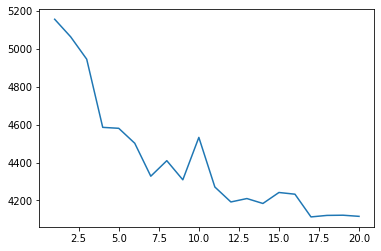

In [12]:
# Plotting cost function result vs number of clusters
number_of_clusters = np.array([i for i in range(1, 21, 1)])
plt.plot(number_of_clusters, cost)

In [17]:
kmode = KModes(n_clusters=6, init='Huang', verbose=0)
clusters = kmode.fit_predict(X)

kmodes = kmode.cluster_centroids_
shape = kmodes.shape

for i in range(shape[0]):
    if sum(kmodes[i, :]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("no-skills cluster")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = kmodes[i, :]
        for j in analysis_dt.columns[np.nonzero(cent)]:
            print(j)


cluster 0: 
num_skills
bio_length
bio_word_count
avg_word_length
design & art

cluster 1: 
num_skills
bio_length
bio_word_count
avg_word_length
writing & translation

cluster 2: 
num_skills
bio_length
bio_word_count
avg_word_length
business & finance

cluster 3: 
num_skills
bio_length
bio_word_count
avg_word_length
num_stop
sales & marketing

cluster 4: 
num_skills
bio_length
bio_word_count
avg_word_length
administrative & secretarial

cluster 5: 
num_skills
bio_length
bio_word_count
avg_word_length
num_stop
programming & development


In [22]:
clust_assigned = kmode.predict(X)

In [23]:
unique, counts = np.unique(clust_assigned, return_counts=True)
dict(zip(unique, counts))

{0: 294, 1: 285, 2: 91, 3: 123, 4: 38, 5: 80}

In [35]:
analysis_dt['cluster'] = list(clust_assigned)

In [40]:
analysis_dt[analysis_dt.cluster == 0]

,index,rating,hourly_rate,has_rating,months_active,num_skills,bio_length,bio_word_count,avg_word_length,num_stop,...,administrative & secretarial,business & finance,design & art,education & training,engineering & architecture,legal,programming & development,sales & marketing,writing & translation,cluster
4,5,100.0,50,1,7.0,5,2,1,2.000000,0,...,0,0,0,0,0,0,1,0,0,0
6,7,100.0,40,1,6.0,5,1081,158,6.600000,25,...,0,0,0,0,1,0,0,0,0,0
7,8,91.7,20,1,6.0,5,2,1,2.000000,0,...,0,0,1,0,0,0,0,0,0,0
8,9,100.0,30,1,4.0,5,2,1,2.000000,0,...,0,0,0,0,0,0,0,1,0,0
14,15,100.0,50,1,27.0,5,2,1,2.000000,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,955,100.0,15,1,6.0,2,2,1,2.000000,0,...,0,0,0,0,0,0,0,1,0,0
903,958,100.0,10,1,61.0,5,564,91,5.208791,39,...,0,0,1,0,0,0,0,0,0,0
904,959,100.0,5,1,13.0,4,478,86,4.623529,37,...,0,0,1,0,0,0,0,0,0,0
905,960,100.0,15,1,97.0,5,385,76,4.366197,29,...,0,0,1,0,0,0,0,0,1,0


## Work in Progress: Using Cross-Validation

This code is a testing ground to use 5-fold CV with random forest regression. Please ignore.

In [8]:
# Creating kfold object
kf = KFold(n_splits=5)  # Define the split - into 2 folds
# returns the number of splitting iterations in the cross-validator
kf.get_n_splits(X_train)

for train_index, test_index in kf.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

In [13]:
# Modeling
# Reference: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py


# Create linear regression object
lm = linear_model.LinearRegression()

# Train model on training data
model = lm.fit(X_train, y_train)

In [24]:
# Perform 5-fold cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated scores", scores)

Cross-validated scores [-0.01803925  0.01615099 -0.13363831 -0.04238569  0.02569149]


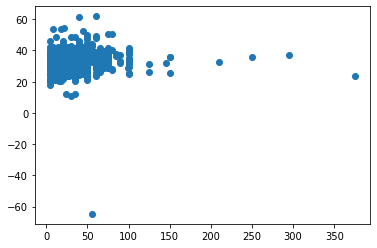

In [23]:
# Make cross validated predictions
predictions = cross_val_predict(model, X_train, y_train, cv=5)
plt.scatter(y_train, predictions)

In [27]:
# Checking R2
accuracy = metrics.r2_score(y_train, predictions)
print("Cross-Predicted Accuracy:", accuracy)

Cross-Predicted Accuracy: -0.018230478379610338
